# Express Deep Learning in Python

## How fast can you build a MLP?

In this first part we will see an introduction of the basic components of a MultiLayer Perceptron (MLP) classifier, or most commonly known as Neural Network.

### 1 - The libraries
Firts let's check we have installed everything we need for this tutorial:

* ***TODO*** Add the information on how to create the conda environment and how to install dependencies:
  * Keras
  * Tensorboard
  * MNist

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist

In [7]:
from keras.callbacks import TensorBoard

### 2 - The dataset

For this quick tutorial we will use the (very much used) [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This is a dataset of images of handwritten digits. Our task is to recognize which digits is displayed in the image: a classification problem.



In [8]:
batch_size = 128
num_classes = 10
epochs = 10
TRAIN_EXAMPLES = 6000#0
TEST_EXAMPLES = 1000#0

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train[:TRAIN_EXAMPLES].astype('float32')
x_test = x_train[:TEST_EXAMPLES].astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:TRAIN_EXAMPLES], num_classes)
y_test = keras.utils.to_categorical(y_test[:TEST_EXAMPLES], num_classes)

### 3 - The model

Deep Learning 

We will define the simplest possible possible deep model: a neural netowrk with a single hidden layer. In theory, this model can represent any function ***TODO*** add a citation here

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

#### Compiling a model in Keras
In Keras, a model can be compiled with the method .compile() in a model. The method takes two parameters: loss and optimizer. Once the model's architecture is defined, i.e. all the layers are given with their respective activation functions and regularization parameters, the model needs to be compiled in order to use it. Remember Keras is an abstraction layer over another abstraction that is the backend, TensorFlow in this case.

***TODO*** add metrics
***TODO*** explain what is the fit function (s

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 0s - loss: 0.7069 - acc: 0.8130 - val_loss: 6.7218 - val_acc: 0.0950
Epoch 2/10
6000/6000 [==============================] - 0s - loss: 0.2730 - acc: 0.9252 - val_loss: 7.3553 - val_acc: 0.0940
Epoch 3/10
6000/6000 [==============================] - 0s - loss: 0.2102 - acc: 0.9443 - val_loss: 7.8410 - val_acc: 0.0950
Epoch 4/10
6000/6000 [==============================] - 0s - loss: 0.1597 - acc: 0.9567 - val_loss: 8.3432 - 

In [15]:
model.loss

'categorical_crossentropy'

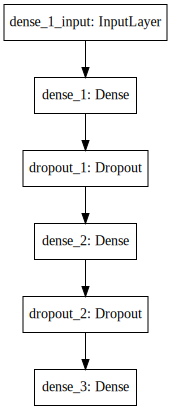

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
input_shape

(28, 28, 1)